# Using JAX and Haiku to build a Graph Neural Network

In [16]:
!pip install -q -U jax dm-haiku jdc pandas

---
### JAX

Last year, I had an oppotunity to devel into the world of JAX whilst working at InstaDeep. My first blopig post seems like an ideal time to share some of that knowledge. JAX is an experimental Python library created by Google's DeepMind for applying accelerated differentiation. JAX can be used to differentiate functions written in NumPy or native Python, just-in-time compile and execute functions on GPUs and TPUs with XLA, and mini-batch repetitious functions with vectorization. Collectively, these qualities place JAX as an ideal candidate for accelerated deep learning research [1].

JAX is inspired by the NumPy API, making usage very familiar for any Python user that has already worked with NumPy [2]. However, unlike NumPy, JAX arrays are immutable; once they are assigned in memory they cannot be changed. As such, JAX includes specific syntax for index manipulation. In the code below, we create a JAX array and change the $1^{st}$ element to a $4$:

In [1]:
import jax.numpy as jnp
array = jnp.array([1, 2, 3])
array = array.at[1].set(4)
array

Array([1, 4, 3], dtype=int32)

It is possible to implement numerous standard NumPy functions in JAX, such as matrix multiplication and vector dot product. However, the true power of JAX comes from three core functions; `grad`, `jit`, and `vmap` (and `pmap` but we don't cover that here). Using `grad`, we can determine the gradient of a given function with respect to an input value. Below we define a function for cubing an input $x$, wrap the function with `grad`, and can subsequently use the wrapped function to obtain the gradient with respect to $x$:

In [2]:
from jax import grad, jit, vmap

fn = lambda x: x**3
grad_fn = grad(fn)
f"f'(1.0) = {grad_fn(1.0)}"

"f'(1.0) = 3.0"

This can be repeated to determine second, third, fourth etc. order derivatives:

In [3]:
import pandas as pd
second_grad_fn = grad(grad(fn))
third_grad_fn = grad(second_grad_fn)

pd.DataFrame({
    'Function': ["f(x)", "f(1.0)","f'(1.0)","f''(1.0)","f'''(1.0)"],
    'Output': ["x^(3)", fn(1.0), grad_fn(1.0), second_grad_fn(1.0), third_grad_fn(1.0)]
})

,Function,Output
0,f(x),x^(3)
1,f(1.0),1.0
2,f'(1.0),3.0
3,f''(1.0),6.0
4,f'''(1.0),6.0


Additionally, one can use `grad` to determine partial derivatives by defining which argument postitions to differentiate with respect to. By default, gradients are calculated with respect to the $0th$ argument. For example for the function $f(x, y) = yx^{2}$, the partial derivatives $\frac{\delta f}{\delta x}$ and $\frac{\delta f}{\delta y}$ for $x = 2$ and $y = 2$ can be calculated like so:

In [4]:
fn = lambda x, y: y*x**2
grad_fn = grad(fn, argnums=(0, 1))
df_dx, df_dy = grad_fn(2.0, 2.0)
print(f"df(2,2)/dx = {df_dx}; df(2,2)/dy = {df_dy}")

df(2,2)/dx = 8.0; df(2,2)/dy = 4.0


To calculate over sets of values we either after to run a loop or, using `vmap`, we can vectorize our gradient functions and calculate derivatives over a batch of values simultaneously:

In [5]:
vmap_grad_fn = vmap(grad_fn)

x = jnp.array([1.0, 2.0, 3.0])
y = jnp.array([1.0, 2.0, 3.0])

df_dx, df_dy = vmap_grad_fn(x, y)
print(f"df/dx = {df_dx}")
print(f"df/dy = {df_dy}")

df/dx = [ 2.  8. 18.]
df/dy = [1. 4. 9.]


Vectorizing in this way makes for noticably faster computation:

In [6]:
%timeit [grad_fn(i,j) for i,j in zip(x,y)]
%timeit vmap_grad_fn(x, y)

1.79 ms ± 19.8 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
787 µs ± 6.56 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)


In addition to vectorizing, `jit` can be used to compile our functions for accelerated performance:

In [7]:
jitted = jit(vmap_grad_fn)
%timeit vmap_grad_fn(x, y)
%timeit jitted(x, y)

767 µs ± 3.28 µs per loop (mean ± std. dev. of 7 runs, 1,000 loops each)
4.53 µs ± 49 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


### Graph Neural Networks

Graph Neural Networks, or GNNs, are an increasingly common deep learning method. Graphs are a type of data structure which are comprised of 'nodes' and 'edges' between nodes [3]. The diagram below depicts a graph with nodes and edges shown as circles and lines respectively [4]:

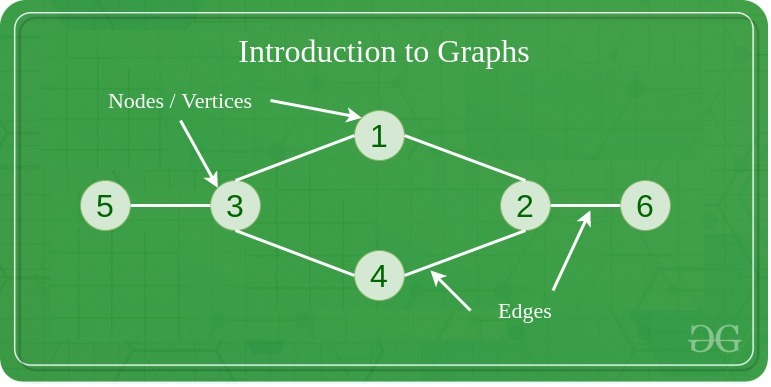

The underlying concept of GNNs is to update the graph by combining each node with its local neighbourhood, obtaining a representation of each node that considers both its original state and its position within the graph [5]. When parsed through a GNN layer, each node contributes a message to its neighbours in step known as message passing; messages are aggregated to form a new node representation. The GNN method we will be implementing here is Graph Convolutional Neural Networks (GCNs) [6]. GCNs are defined mathematically:

$$X' = \hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}X\Theta$$

where $\hat{A} = A + I$ is the graph adjacency matrix with self-loops, $\hat{D}$ is the diagonal degree matrix of $\hat{A}$, $X$ is the original node feature matrix, $\Theta$ is a non-linear transformation like an MLP, and $X'$ is the updated node features. By using matrix multiplication of $\hat{A}$ and $X$ we sum the local neighbourhood of each node with itself, performing message passing and aggregation. To prevent aggregation being dependent on the degree of each node, $\hat{D}^{-\frac{1}{2}}$ is used to symmetrically normalise the graph adjacency matrix.

### Haiku

Haiku is wrapper library for applying JAX to machine learning developed by DeepMind, allowing creation of JAX trees of model parameters using an object orientated approach [7]. So how do we use Haiku to construct a GCN? First we need to define a GCN layer class. Note that class methods written below are split across cells to allow additional markdown explanations between methods. This is done using `%%add_to **insert class name**` from jupyter dynamic cells.

Below we have our GCNLayer class with its constructor method; we will use this to define the depth and width of $\Theta$ and our non-linear activation function. Unlike PyTorch, we do not define our layers explicitly in the constructor method; this is due JAX being built on pure functions. To prepare our class, we will later apply `hk.transform` to make our object-oriented structure JAX compatible.

In [8]:
# GCN layer in JAX
import haiku as hk
import jax
from functools import partial # for using jit decorators
import jdc # allows classes to be split into multiple cells

class GCNLayer(hk.Module):
    def __init__(self, dims: tuple[int], activation = jax.nn.relu) -> None:
        super(GCNLayer, self).__init__()
        self.dims = dims
        self.activation = activation

Next we need a method for symmetrically normalizing our adjacency matrix. Here we take $\hat{A}$ as input, determine the degree of each node, create $\hat{D}^{-\frac{1}{2}}$, compute $\hat{D}^{-\frac{1}{2}}\hat{A}\hat{D}^{-\frac{1}{2}}$, and output the normalized adjacency matrix:

In [9]:
%%add_to GCNLayer
def normalize_adj(self, adj: jnp.ndarray) -> jnp.ndarray:
    # adjacency normalization method
    degree = jnp.sum(adj, axis=-1)
    degree_inv_sqrt = jnp.power(degree, -0.5)
    degree_inv_sqrt = jnp.where(jnp.isinf(degree_inv_sqrt), 0, degree_inv_sqrt)
    degree_inv_sqrt = jnp.diag(degree_inv_sqrt)
    adj_norm = jnp.matmul(degree_inv_sqrt, adj)
    adj_norm = jnp.matmul(adj_norm, degree_inv_sqrt)
    return adj_norm

Now a call function is required to run a single convolutional computation. First, we ensure self-loops are applied by setting the adjacency diagonal, then we normalize the adjacency, apply the MLP to the node features, $x$, and finally we compute the matrix multiplication:

In [10]:
%%add_to GCNLayer
def __call__(self, x: jnp.ndarray, adj: jnp.ndarray, **kwargs) -> jnp.ndarray:
    # one forward pass through a GCN layer
    # Add self-loops to the adjacency matrix
    adj = jnp.fill_diagonal(adj, 1, inplace=False)

    # Normalize adjacency matrix
    adj = self.normalize_adj(adj)

    # apply Theta transformation
    for dim in self.dims:
        x = hk.Linear(dim)(x)
        x = self.activation(x)
    x = jnp.matmul(adj, x)

    return x

Now we have our GCN layer class, we need to be able to pool our output graph for global predictions. To do this, we can define a Pool class with different pooling methods and a GraphPooling class for wrapping and applying pooling. Below we have a Pool class for applying either sum, mean, or max pooling. Each function takes the node feature matrix, $x$, an index array for batched graphs indicating which graph each node belongs to (similarly to PyTorch Geometric), and an array of the number of nodes in each graph. The reason num_nodes is an explicit input is due to `jnp.unique` being typically non-jittable.

In [11]:
# Pooling layer
class Pool:
    def sum(x: jnp.ndarray, batch: jnp.ndarray, num_nodes: jnp.ndarray) -> jnp.ndarray:
        out_shape = num_nodes.shape[0]
        return jax.ops.segment_sum(x, batch, out_shape)

    def mean(x: jnp.ndarray, batch: jnp.ndarray, num_nodes: jnp.ndarray) -> jnp.ndarray:
        added = Pool.sum(x, batch, num_nodes)
        return added / num_nodes

    def max(x: jnp.ndarray, batch: jnp.ndarray, num_nodes: jnp.ndarray) -> jnp.ndarray:
        return jax.ops.segment_max(x, batch, num_nodes.shape[0])

    def identity(x: jnp.ndarray, batch: jnp.ndarray, num_nodes: jnp.ndarray) -> jnp.ndarray:
        return x

Next we have our wrapper class for applying graph pooling:

In [12]:
# graph pooling wrapper
from typing import Any, Callable
class GraphPooling:
    def __init__(self, pool: Callable) -> None:
        self.pool = pool

    def __call__(self, x: jnp.ndarray, batch: jnp.ndarray, num_nodes: jnp.ndarray) -> jnp.ndarray:
        return self.pool(x, batch, num_nodes)

Let's test these pooling classes on 2 example batched graphs, each with 2 nodes:

In [19]:
max_pool = GraphPooling(Pool.mean)
x = jnp.array([[1, 2], [3, 4], [5, 6], [7, 8]])
batch = jnp.array([0, 0, 1, 1])
num_nodes = jnp.array([[2], [2]])
max_pool(x, batch, num_nodes)

Array([[2., 3.],
       [6., 7.]], dtype=float32)

Great! Our two graphs have both been pooled into 1D vector representations. We now have the components to make our GCN model. Below we use the GCN layer to perform sequential 1-hop updates before global pooling is applied. Once all GCN computations have been performed the outputs are concatenated into one vector, representing our graph from $0$ to $n$-hops. To obtain a singular regression value for the input graph, we can use a final linear layer:

In [14]:
# Full GCN model
class GCNModel(hk.Module):

    def __init__(self, dims: tuple[tuple[int]], activation = jax.nn.relu, pool: Callable=Pool.max,):
        super(GCNModel, self).__init__()
        self.dims = dims # dimensions of the GCN layers
        self.activation = activation # activation function
        self.pool = GraphPooling(pool) # pooling function

    def __call__(self, x, adj, batch, num_nodes) -> Any:
        output = [self.pool(x, batch, num_nodes)]
        for dim in self.dims:
            x = GCNLayer(dim, self.activation)(x, adj)
            output.append(self.pool(x, batch, num_nodes))
        x = jnp.concatenate(output, axis=-1)
        x = hk.Linear(1)(x)
        return x

Now that we have our model class, it needs to be wrapped for transformation with `hk.transform`. To do this, a function which both defines the model with hyperparameters and parses an example input is required; below, the method called `_forward` performs this function. A constructor function is also required to define our hyperparameters, transform our forward pass method, and initialise our model parameters with example input data:

In [15]:
# GCN wrapper class
class GCN:
    def __init__(
        self, hyperparameters: dict, x: jnp.ndarray,
        adj: jnp.ndarray, batch: jnp.ndarray, num_nodes: jnp.ndarray,
        rng: jnp.ndarray = jax.random.PRNGKey(42),
    ) -> None:
        super(GCN).__init__()
        self.hyperparameters = hyperparameters
        self.forward = hk.transform(self._forward)
        self.forward = hk.without_apply_rng(self.forward)
        self.parameters = self.forward.init(rng, x, adj, batch, num_nodes)

    def _forward(self, x: jnp.ndarray, adj: jnp.ndarray, batch: jnp.ndarray, num_nodes: jnp.ndarray) -> jnp.ndarray:
        return GCNModel(**self.hyperparameters)(x, adj, batch, num_nodes)



Note: for initialisation an RNG key is needed. This is typically the case for JAX functions that involve random number generation.

Finally, a call function is required for running the model. In Haiku, model parameters are stored in hierarchical dictionaries which need to be input with each call:

In [16]:
%%add_to GCN
@partial(jit, static_argnums=(0,))
def __call__(self, x: jnp.ndarray, adj: jnp.ndarray, batch: jnp.ndarray, num_nodes: jnp.ndarray) -> jnp.ndarray:
    return self.forward.apply(self.parameters, x, adj, batch, num_nodes)

Here, we are able to add `jit`, wrapping our whole haiku model for rapid computation. As `jit` can be applied as a decorator, it simply needs to be added above our method. However, as our GCN class is not an array `self` must be defined as a static argument by wrapping `jit` with `partial`.

With our model wrapped, how does this work in practice? Let's see how the model can be used with an example graph input. Below, we have the hyperparameters defined in a dictionary for a model with two GCN layers each with one internal 64 dim Linear layer, and one graph with 5 nodes defined in a dictionary. Using these two dictionaries, we can initialize our GCN before performing a forward pass over our graph:

In [17]:
hyperparameters = {
    'dims': ((64,), (64,)),
    'activation': jax.nn.relu,
    'pool': Pool.mean
}
graph = {
    'x': jax.random.normal(jax.random.PRNGKey(42), (5, 2)), # 5 nodes with 2 features
    'batch': jnp.array([0, 0, 0, 0, 0,]), # batch index for each node
    'num_nodes': jnp.array([[5]]), # number of nodes in each graph
    'adj': jnp.array([[0,1,0,0,0], [1,0,1,1,0], [0,1,0,0,0], [0,1,0,0,1], [0,0,0,1,0]])
}

# initialise model
model = GCN(hyperparameters=hyperparameters, **graph)
# forward pass
model(**graph)

Array([[-0.10328715]], dtype=float32)

How do we handle multiple graphs simultaneously? Due to graphs varying in size with differing number of nodes, `vmap` is difficult to apply here. Alternatively, we can stack graphs togther and treat them as a single input. As disconnected graphs will possess no shared edges no message passing will occur between graphs. Below we create two graphs with the same structure defined in one shared adjacency matrix, but with differing features, producing two different outputs:

In [18]:
import numpy as np
graphs = {
    'x': jax.random.normal(jax.random.PRNGKey(42), (10, 2)), # 10 nodes with 2 features
    'batch': jnp.array([0, 0, 0, 0, 0, 1, 1, 1, 1, 1]), # batch index for each node
    'num_nodes': jnp.array([[5], [5]]), # number of nodes in each graph
    'adj': np.zeros((10, 10), dtype=jnp.int32)
}

graphs['adj'][:5,:5] = graph['adj']
graphs['adj'][-5:,-5:] = graph['adj']
graphs['adj'] = jnp.array(graphs['adj'])

model(**graphs)

Array([[-0.16933393],
       [-0.07369839]], dtype=float32)

And there you have it! A brief introduction into writing GNNs in JAX and Haiku. For training, `grad` can be used to perform backpropagation by calculating the partial derivatives of the loss function with respect to model parameters; DeepMind has developed another library called Optax [8] for loss functions and optimizers, which we can take a look at another day.

### References:
[1] https://deepmind.google/discover/blog/using-jax-to-accelerate-our-research/

[2] https://jax.readthedocs.io/en/latest/notebooks/thinking_in_jax.html

[3] https://en.wikipedia.org/wiki/Graph_theory

[4] https://www.geeksforgeeks.org/introduction-to-graphs-data-structure-and-algorithm-tutorials/

[5] https://www.cs.mcgill.ca/~wlh/grl_book/files/GRL_Book.pdf

[6] https://arxiv.org/abs/1609.02907

[7] https://github.com/google-deepmind/dm-haiku

[8] https://github.com/google-deepmind/optax/